In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import pandas as pd
from scipy import stats
import time
import h5py
import ira_mod
sofi = ira_mod.SOFI()

def load_molecule_hdf5(filename, idx):
    """Load single molecule from HDF5 file"""
    with h5py.File(filename, 'r') as f:
        # Get coordinates and reshape
        coords_flat = f['coords'][idx]
        coords = coords_flat.reshape(-1, 3)
        
        # Get atom types (decode bytes to string)
        atom_types_str = f['atom_types'][idx]
        if isinstance(atom_types_str, bytes):
            atom_types_str = atom_types_str.decode('utf-8')
        atom_types = atom_types_str.split('|')
        
        # Get strings (decode bytes to string if necessary)
        smiles = f['smiles'][idx]
        if isinstance(smiles, bytes):
            smiles = smiles.decode('utf-8')
            
        selfies = f['selfies'][idx]
        if isinstance(selfies, bytes):
            selfies = selfies.decode('utf-8')
        
        return {
            'atom_types': atom_types,
            'coords': coords,
            'smiles': smiles,
            'selfies': selfies
        }

def analyze_sym_thr_range(filename, test_indices, sym_thr_values):
    """
    Analyze multiple sym_thr values on a subset of molecules
    """
    results = []
    
    print(f"Testing {len(sym_thr_values)} threshold values on {len(test_indices)} molecules...")
    
    for i, idx in enumerate(test_indices):
        if (i+1) % 1000 == 0:
            print(f"Processing molecule {i+1}/{len(test_indices)} (index {idx})")
        
        # Load molecule
        mol = load_molecule_hdf5(filename, idx)
        atoms = mol["atom_types"]
        coords =np.array(mol["coords"], dtype=float)
        nat = len(atoms)
            
        # Create atom type mapping
        unique_atoms = list(set(atoms))
        atom_type_map = {atom: i+1 for i, atom in enumerate(sorted(unique_atoms))}
        typ = np.array([atom_type_map[atom] for atom in atoms], dtype=int)
        
        # Test different sym_thr values
        mol_results = {'molecule_idx': idx, 'n_atoms': nat, 'atom_types': len(unique_atoms)}
        
        for sym_thr in sym_thr_values:
            try:
                sym = sofi.compute(nat, typ, coords, sym_thr)
                # Check if linear
                is_collinear, linear_axis = sofi.check_collinear(nat, coords)
                n_sym = sym.n_sym
                max_hausdorff = np.max(sym.dHausdorff)
                mean_hausdorff = np.mean(sym.dHausdorff)
                if is_collinear:
                    if sym.n_sym == 1:
                        pg = "C∞v"
                        n_sym = sym.n_sym
                    else:
                        pg = "D∞h"
                        n_sym = sym.n_sym
                else:
                    pg = sym.pg
                
                mol_results[f'pg_{sym_thr}'] = pg
                mol_results[f'n_sym_{sym_thr}'] = n_sym
                mol_results[f'max_hausdorff_{sym_thr}'] = max_hausdorff
                mol_results[f'mean_hausdorff_{sym_thr}'] = mean_hausdorff
                mol_results[f'is_linear'] = is_collinear
                
            except Exception as e:
                print(f"Error with molecule {idx} at sym_thr {sym_thr}: {e}")
                mol_results[f'pg_{sym_thr}'] = 'ERROR'
                mol_results[f'n_sym_{sym_thr}'] = 0
                mol_results[f'max_hausdorff_{sym_thr}'] = np.inf
                mol_results[f'mean_hausdorff_{sym_thr}'] = np.inf
        
        results.append(mol_results)
    
    return pd.DataFrame(results)

def analyze_stability_metrics(df, sym_thr_values):
    """
    Analyze stability metrics across different sym_thr values
    """
    print("\n=== STABILITY ANALYSIS ===")
    
    metrics = {}
    
    # 1. Point group distribution stability
    for sym_thr in sym_thr_values:
        pg_col = f'pg_{sym_thr}'
        if pg_col in df.columns:
            pg_counts = df[pg_col].value_counts()
            metrics[f'pg_diversity_{sym_thr}'] = len(pg_counts)  # Number of unique PGs
            metrics[f'pg_entropy_{sym_thr}'] = stats.entropy(pg_counts.values)  # Shannon entropy
            metrics[f'most_common_pg_{sym_thr}'] = pg_counts.index[0]
            metrics[f'most_common_pg_frac_{sym_thr}'] = pg_counts.iloc[0] / len(df)
    
    # 2. Consistency between adjacent thresholds
    consistency_scores = []
    for i in range(len(sym_thr_values) - 1):
        thr1, thr2 = sym_thr_values[i], sym_thr_values[i+1]
        pg_col1, pg_col2 = f'pg_{thr1}', f'pg_{thr2}'
        
        if pg_col1 in df.columns and pg_col2 in df.columns:
            # Calculate agreement between adjacent thresholds
            agreement = (df[pg_col1] == df[pg_col2]).mean()
            consistency_scores.append(agreement)
            metrics[f'consistency_{thr1}_{thr2}'] = agreement
    
    # 3. Hausdorff distance statistics
    hausdorff_stats = {}
    for sym_thr in sym_thr_values:
        max_haus_col = f'max_hausdorff_{sym_thr}'
        mean_haus_col = f'mean_hausdorff_{sym_thr}'
        
        if max_haus_col in df.columns:
            # Filter out infinite values
            max_haus_finite = df[max_haus_col][np.isfinite(df[max_haus_col])]
            mean_haus_finite = df[mean_haus_col][np.isfinite(df[mean_haus_col])]
            
            hausdorff_stats[sym_thr] = {
                'max_hausdorff_mean': np.mean(max_haus_finite),
                'max_hausdorff_std': np.std(max_haus_finite),
                'mean_hausdorff_mean': np.mean(mean_haus_finite),
                'mean_hausdorff_std': np.std(mean_haus_finite),
                'frac_below_threshold': (max_haus_finite < sym_thr).mean()
            }
    
    return metrics, consistency_scores, hausdorff_stats

def plot_analysis_results(df, sym_thr_values, consistency_scores, hausdorff_stats):
    """
    Create comprehensive plots for sym_thr analysis
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Point group distribution
    ax = axes[0, 0]
    pg_diversity = [len(df[f'pg_{thr}'].value_counts()) for thr in sym_thr_values 
                   if f'pg_{thr}' in df.columns]
    ax.plot(sym_thr_values[:len(pg_diversity)], pg_diversity, 'o-')
    ax.set_xlabel('sym_thr')
    ax.set_ylabel('Number of Unique Point Groups')
    ax.set_title('Point Group Diversity vs Threshold')
    ax.grid(True)
    
    # 2. Consistency between adjacent thresholds
    ax = axes[0, 1]
    if consistency_scores:
        ax.plot(sym_thr_values[:-1], consistency_scores, 'o-', color='red')
        ax.set_xlabel('sym_thr (lower of pair)')
        ax.set_ylabel('Agreement with Next Threshold')
        ax.set_title('Consistency Between Adjacent Thresholds')
        ax.grid(True)
        ax.set_ylim([0, 1.05])
    
    # 3. Most common point groups
    ax = axes[0, 2]
    most_common_fractions = []
    for thr in sym_thr_values:
        pg_col = f'pg_{thr}'
        if pg_col in df.columns:
            pg_counts = df[pg_col].value_counts()
            most_common_fractions.append(pg_counts.iloc[0] / len(df))
    
    if most_common_fractions:
        ax.plot(sym_thr_values[:len(most_common_fractions)], most_common_fractions, 'o-', color='green')
        ax.set_xlabel('sym_thr')
        ax.set_ylabel('Fraction of Most Common PG')
        ax.set_title('Dominance of Most Common Point Group')
        ax.grid(True)
    
    # 4. Average Hausdorff distances
    ax = axes[1, 0]
    thresholds = list(hausdorff_stats.keys())
    max_haus_means = [hausdorff_stats[thr]['max_hausdorff_mean'] for thr in thresholds]
    max_haus_stds = [hausdorff_stats[thr]['max_hausdorff_std'] for thr in thresholds]
    
    ax.errorbar(thresholds, max_haus_means, yerr=max_haus_stds, fmt='o-', capsize=5)
    ax.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Common threshold')
    ax.set_xlabel('sym_thr')
    ax.set_ylabel('Average Max Hausdorff Distance')
    ax.set_title('Hausdorff Distance vs Threshold')
    ax.legend()
    ax.grid(True)
    
    # 5. Fraction of molecules with distances below threshold
    ax = axes[1, 1]
    fractions_below = [hausdorff_stats[thr]['frac_below_threshold'] for thr in thresholds]
    ax.plot(thresholds, fractions_below, 'o-', color='purple')
    ax.set_xlabel('sym_thr')
    ax.set_ylabel('Fraction Below Threshold')
    ax.set_title('Fraction of Max Hausdorff < sym_thr')
    ax.grid(True)
    ax.set_ylim([0, 1.05])
    
    # 6. Point group histogram for optimal threshold
    ax = axes[1, 2]
    # Find optimal threshold (highest consistency score)
    if consistency_scores:
        optimal_idx = np.argmax(consistency_scores)
        optimal_thr = sym_thr_values[optimal_idx]
        
        pg_col = f'pg_{optimal_thr}'
        if pg_col in df.columns:
            pg_counts = df[pg_col].value_counts().head(10)  # Top 10 most common
            pg_counts.plot(kind='bar', ax=ax, rot=45)
            ax.set_title(f'Top Point Groups at Optimal sym_thr={optimal_thr}')
            ax.set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()

def recommend_optimal_sym_thr(df, sym_thr_values, consistency_scores, hausdorff_stats):
    """
    Provide recommendations for optimal sym_thr based on analysis
    """
    print("\n=== RECOMMENDATIONS ===")
    
    if not consistency_scores:
        print("Not enough data for consistency analysis")
        return None
    
    # Find threshold with highest consistency
    optimal_idx = np.argmax(consistency_scores)
    optimal_thr_consistency = sym_thr_values[optimal_idx]
    max_consistency = consistency_scores[optimal_idx]
    
    print(f"1. CONSISTENCY-BASED: sym_thr = {optimal_thr_consistency:.3f}")
    print(f"   - Agreement with next threshold: {max_consistency:.1%}")
    
    # Find threshold where ~95% of molecules have max_hausdorff < sym_thr
    coverage_thresholds = []
    for thr in hausdorff_stats:
        if hausdorff_stats[thr]['frac_below_threshold'] >= 0.95:
            coverage_thresholds.append(thr)
    
    if coverage_thresholds:
        optimal_thr_coverage = min(coverage_thresholds)
        print(f"2. COVERAGE-BASED: sym_thr = {optimal_thr_coverage:.3f}")
        print(f"   - 95% of molecules have max_hausdorff below this threshold")
    else:
        print("2. COVERAGE-BASED: No threshold achieves 95% coverage")
    
    # Find threshold with reasonable point group diversity
    pg_diversities = []
    for thr in sym_thr_values:
        pg_col = f'pg_{thr}'
        if pg_col in df.columns:
            diversity = len(df[pg_col].value_counts())
            pg_diversities.append((thr, diversity))
    
    if pg_diversities:
        # Look for "elbow" in diversity curve (rapid change)
        diversities = [d[1] for d in pg_diversities]
        thresholds = [d[0] for d in pg_diversities]
        
        # Find point where diversity stabilizes (derivative becomes small)
        derivatives = np.diff(diversities)
        if len(derivatives) > 1:
            stable_idx = np.argmin(np.abs(derivatives[1:])) + 1  # Skip first derivative
            optimal_thr_diversity = thresholds[stable_idx]
            print(f"3. DIVERSITY-BASED: sym_thr = {optimal_thr_diversity:.3f}")
            print(f"   - Point group diversity stabilizes here ({diversities[stable_idx]} unique PGs)")
    
    # Final recommendation
    print(f"\n🎯 RECOMMENDED sym_thr: {optimal_thr_consistency:.3f}")
    print("   Based on highest consistency between adjacent thresholds")
    
    return optimal_thr_consistency

=== FINDING OPTIMAL sym_thr ===
Testing thresholds: [0.1        0.1033391  0.10678971 0.11035553 0.11404041 0.11784834
 0.12178342 0.1258499  0.13005215 0.13439473 0.13888231 0.14351974
 0.14831201 0.15326431 0.15838196 0.1636705  0.16913563 0.17478324
 0.18061944 0.18665051 0.19288297 0.19932353 0.20597915 0.21285701
 0.21996453 0.22730938 0.23489947 0.24274301 0.25084846 0.25922455
 0.26788033 0.27682513 0.28606861 0.29562074 0.30549183 0.31569252
 0.32623382 0.33712711 0.34838414 0.36001705 0.37203839 0.38446114
 0.3972987  0.41056492 0.42427411 0.43844107 0.45308108 0.46820993
 0.48384394 0.5       ]
Testing on 10000 randomly selected molecules
Testing 50 threshold values on 10000 molecules...
Processing molecule 1000/10000 (index 163855)
Processing molecule 2000/10000 (index 805141)
Processing molecule 3000/10000 (index 253458)
Processing molecule 4000/10000 (index 326228)
Processing molecule 5000/10000 (index 812863)
Processing molecule 6000/10000 (index 19532)
Processing molecul

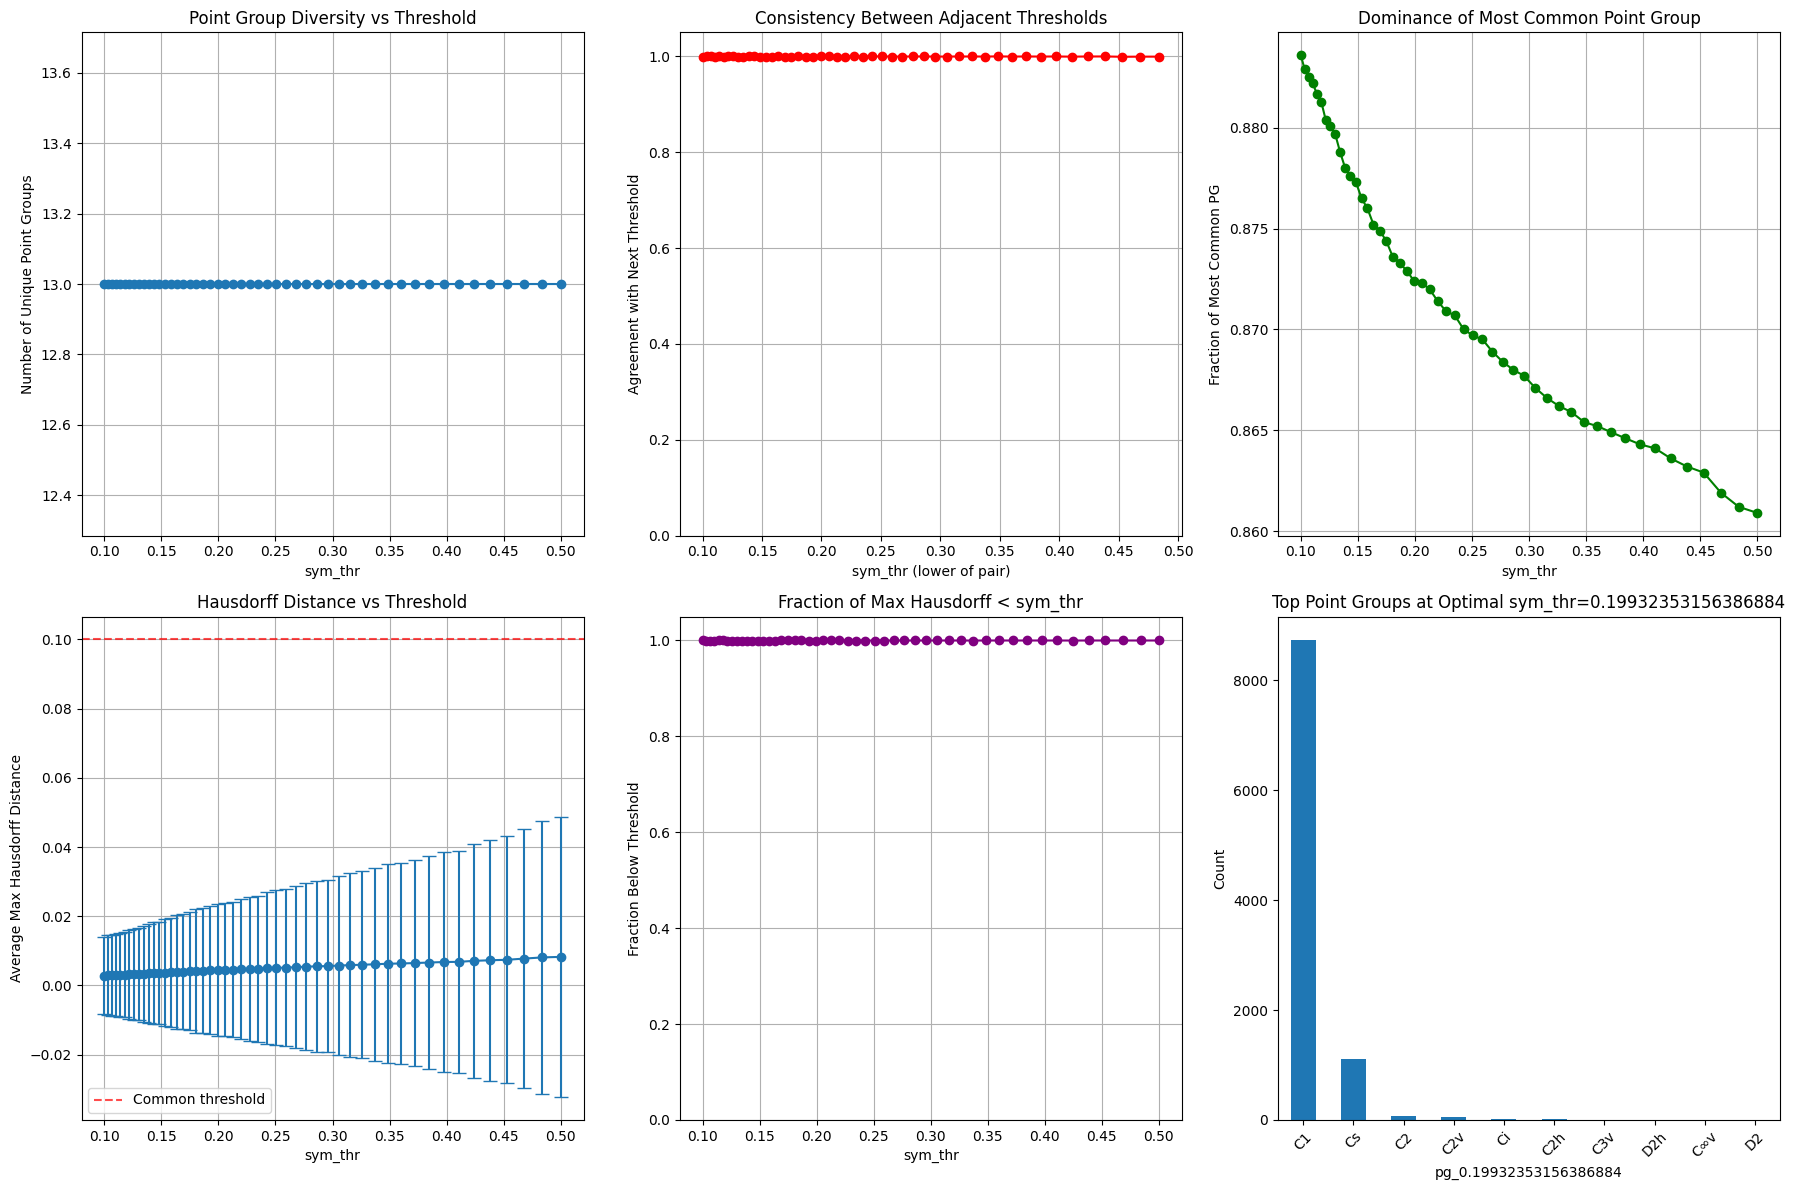


=== RECOMMENDATIONS ===
1. CONSISTENCY-BASED: sym_thr = 0.199
   - Agreement with next threshold: 100.0%
2. COVERAGE-BASED: sym_thr = 0.100
   - 95% of molecules have max_hausdorff below this threshold
3. DIVERSITY-BASED: sym_thr = 0.103
   - Point group diversity stabilizes here (13 unique PGs)

🎯 RECOMMENDED sym_thr: 0.199
   Based on highest consistency between adjacent thresholds

Detailed results saved to 'sym_thr_analysis_results.csv'


In [7]:
def find_optimal_sym_thr(filename, n_test_molecules=1000, 
                        sym_thr_range=(0.1, 0.5), n_thresholds=50):
    """
    Complete workflow to find optimal sym_thr
    """
    print("=== FINDING OPTIMAL sym_thr ===")
    
    # Generate threshold values to test (logarithmic spacing works well)
    sym_thr_values = np.logspace(np.log10(sym_thr_range[0]), 
                                np.log10(sym_thr_range[1]), 
                                n_thresholds)
    
    print(f"Testing thresholds: {sym_thr_values}")
    
    # Select random test molecules
    with h5py.File(filename, 'r') as f:
        total_molecules = len(f['coords'])
    
    np.random.seed(42)  # For reproducibility
    test_indices = np.random.choice(total_molecules, 
                                   size=min(n_test_molecules, total_molecules), 
                                   replace=False)
    
    print(f"Testing on {len(test_indices)} randomly selected molecules")
    
    # Run analysis
    start_time = time.time()
    df = analyze_sym_thr_range(filename, test_indices, sym_thr_values)
    end_time = time.time()
    
    print(f"\nAnalysis completed in {end_time - start_time:.1f} seconds")
    
    # Analyze results
    metrics, consistency_scores, hausdorff_stats = analyze_stability_metrics(df, sym_thr_values)
    
    # Plot results
    plot_analysis_results(df, sym_thr_values, consistency_scores, hausdorff_stats)
    
    # Get recommendation
    optimal_sym_thr = recommend_optimal_sym_thr(df, sym_thr_values, consistency_scores, hausdorff_stats)
    
    # Save detailed results
    df.to_csv('sym_thr_analysis_results.csv', index=False)
    print(f"\nDetailed results saved to 'sym_thr_analysis_results.csv'")
    
    return optimal_sym_thr, df

optimal_thr, results_df = find_optimal_sym_thr("mol3d_data/molecules3d_million_1.h5", n_test_molecules=10000)     